# Simple Linear Regression using `theano`

To solve our simple linear regression problem with gradient descent using `numpy`, we coded each individual equation, which included the calculation of the derivatives (which we calculated first by hand). With `theano`, we'll avoid having to code each individual equation by building a computational graph, and letting `theano` handle the differentiation for us. 

With the automatic differentiation that `theano` offers, we'll still have to specify some details on how to take the derivatives, but we will no longer have to calculate any derivatives by hand! This will be incredibly beneficial when we move to neural networks that have hundreds of thousands of parameters (imagine calculating the derivatives for all those by hand). 

## Computational Graphs for Simple Linear Regression 

Recall the computational graphs that we used to visualize the forward and backward propagation steps in solving our simple linear regression problem with gradient descent: 

### Forward Propagation 

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/simp_linear_comp_graph_forprop.png?raw=true" width=400\>

### Backward Propagation 

<img src="https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/imgs/custom/simp_linear_comp_graph_backprop.png?raw=true" width=400\>

### Building a computational graph with `theano`

For the most part, building up simple linear regression as a computational graph using `theano` is going to look pretty similar to our `numpy` implementation, but with different syntax. As mentioned above, the biggest benefit we'll get from building this graph will be automatic differentiation. We'll simply be able to tell `theano` that we want the derivative of some quantity with respect to some coefficient/parameter, and it'll calculate the derivative for us. 

Let's look at how to code this up one piece at a time, discussing along the way how it works... 

In [1]:
import numpy as np
import theano.tensor as T
import theano
from datasets.general import gen_simple_linear
from utils.plotting import plot_errors
%matplotlib inline

In [2]:
def get_theano_graph(): 
    learning_rate = 0.1
    # 1. Define placeholder matrices for inputs. 
    xs, ys = T.dmatrices('xs', 'ys') # returns one or more matrices of type `float64`
    # 2. Define randomly initialized floats for beta_0 and beta_1. 
    beta_0 = theano.shared(np.random.random(), name='beta_0')
    beta_1 = theano.shared(np.random.random(), name='beta_1')

    # 3. Define the equation that generates predictions. 
    yhats = beta_0 + beta_1 * xs
    # 4. Define the equation that generates our errors. 
    es = 0.5 * (ys - yhats) ** 2
    # 5. Define the aggregate cost (mean of squared errors)
    E = es.mean()
    # 6. Take advantage of `theanos` automatic differentiation. 
    d_beta_0, d_beta_1 = T.grad(E, [beta_0, beta_1])
    # 7. Define a function that we can feed inputs to, obtain outputs from, and 
    #    perform updates on our coefficients / train them. 
    train = theano.function(inputs=[xs, ys], outputs=[E, yhats], 
                            updates=((beta_0, beta_0 - learning_rate * d_beta_0), 
                                     (beta_1, beta_1 - learning_rate * d_beta_1)))

    return train

From a high level, `get_theano_graph` returns a `theano.function` object that performs one iteration of our gradient descent procedure. It performs forward propagation (steps `1-5`) as well as backward propagation (step `6`). The final step, `7`, simply [generates a callable function](http://deeplearning.net/software/theano/library/compile/function.html#module-theano.compile.function) that we can later use to perform one iteration of our gradient descent procedure. 

The magic of the automatic differentiation that `theano` offers is what we see in step `6`. To take advantage of it, we have to use `T.grad`, passing as the first argument the quantity to take the derivative of and as the second what to take the derivative with respect to. Note here that we have to take the mean of the squared-error and then differentiate that, as opposed to differentiating the individual errors as we did with the `numpy` implementation.  The `T.grad` function expects a scalar input, and mathematically it's all the same, since the derivative of a sum is equal to the sum of the individual derivatives. 

The callable function generated in step `7` can take inputs (via the `inputs` argument), run them through the graph, and produce outputs (via the `outputs` argument). This function has side effects that are specified by the `updates` argument, namely that we update the values of `beta_0` and `beta_1`. Ultimately, these updates are how we learn the values for these coefficients. 

Finally, it's worth noting that `beta_0` and `beta_1` are defined as [shared variables](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables) (step `2`). When we define them in this way, `theano` knows that it should **share** the values of these variables across calls to the function that is generated in step `7`. That is, `theano` should use the values of `beta_0` and `beta_1` from the previous call to the function as the values that it uses when it updates them in the current call. This ensures that we are continuously updating `beta_0` and `beta_1` through each call to the function, and over time converging to their true values.

Now, we'll write some code that actually uses this function to learn the true values for a given `beta_0` and `beta_1`. 

Final Error: 2.5079645969181413e-28


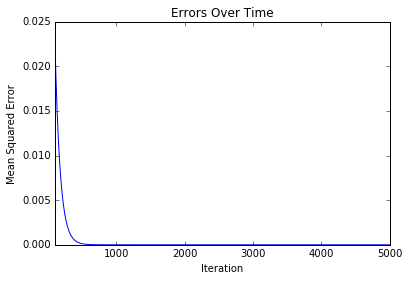

In [3]:
# Randomly generate a beta_0, beta_1, and number of observations, used to generate 
# fake data to fit. We need a minimum of 2 obs. 
true_beta_0, true_beta_1 = np.random.randint(2, 10, size=2) 
n_obs = np.random.randint(9500, 10500) 

# Generate the theano graph. This is in a function so that we can run this cell multiple times
# and obtain different randomly generated values for `beta_0` and `beta_1`. 
theano_linear_graph = get_theano_graph()

# Generate the data that follows a linear relationship specified 
# by true_beta_0 and true_beta_1.
xs, ys = gen_simple_linear(true_beta_0, true_beta_1, n_obs)

# Perform iterations (forward & backward prop.) over the theano graph
mean_squared_errors = []
for _ in range(5000): 
    mean_squared_error, yhats = theano_linear_graph(xs, ys)
    mean_squared_errors.append(mean_squared_error)    
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

Once we obtain the callable function from `get_theano_graph`, there is only one real difference from our implementation using `numpy`. Rather than performing our looping (e.g. iterations of gradient descent) within the function that we generated, we perform the looping external to the function, calling the function `theano_linear_graph` each time through the loop. This isn't really a notable difference, though, and makes sense given that the function generated from `get_theano_graph` is defined to perform **one** iteration of gradient descent. Note above, too, that `xs` and `ys` are passed as inputs to this callable function, just as the function signature specifies. 

In the end, we see that we can solve our linear regression problem using this computational graph that we defined in `theano`, and that just as with the `numpy` implementation, we are able to obtain what is effectively a 0 mean squared error.  

Next, we'll code this up using `tensorflow`... 